# Market clearing with non-merchant storage

In [216]:
# Import packages
using JuMP, HiGHS
using CSV, DataFrames
using Plots
using DataStructures

## Input data

Here you can change the parameters for the test case under consideration. For the parameters of the generators, loads and the final level of the storage, modify the csv files directly: "data_gen.csv", "data_load.csv" and "data_stg.csv".

In [217]:
# Input number of days, number of hours per day
nb_d = 2
t_per_d = 2
nb_t_tot = nb_d * t_per_d

# Input number of generators and loads
nb_g = 2
nb_l = 1

# Storage data
E_max = 2.5 # Storage capacity
E_0 = 0.0 # Initial state of energy
E_df = CSV.read("data_stg.csv", DataFrame) # Final state of energy (optionnal)

Row,time,soe_end
,Int64,Float64
1,2,1.25
2,4,1.25


In [218]:
# Generators
G_df = CSV.read("data_gen.csv", DataFrame) # Full dataframe

Row,time,gen,max,cost
,Int64,Int64,Int64,Int64
1,1,1,2,4
2,1,2,2,8
3,2,1,2,5
4,2,2,2,10
5,3,1,2,2
6,3,2,2,9
7,4,1,2,6
8,4,2,2,11


In [219]:
# Loads
L_df = CSV.read("data_load.csv", DataFrame) # Full dataframe

Row,time,load,max,utility
,Int64,Int64,Int64,Int64
1,1,1,0,12
2,2,1,1,12
3,3,1,3,12
4,4,1,3,12


In [220]:
g_df = groupby(G_df, [:time, :gen]) # Group by time and generator
l_df = groupby(L_df, [:time, :load]) # Group by time and load

# Sets
G = [i for i in 1:nb_g]
L = [i for i in 1:nb_l]
T_all = ["$i" for i in 1:nb_t_tot]
;

## Function for the market clearing

This function performs the market clearing over a specified interval and for given initial and final levels of the storage system (or no constraint on the final level).

In [221]:
function mc_storage(t_start, t_end, final_level, E_init)
    model = Model(HiGHS.Optimizer)
    set_silent(model)

    T = [i for i in t_start:t_end] # Define the time interval for the specified start and end
    
    # Introduce the variables
    @variables model begin
         p[g in G, t in T] >= 0 # Generators output, non-negative
         e[t in T] >= 0 # Storage level, non-negative
         b[t in T] # Storage charge (or discharge for b negative)
         d[l in L, t in T] >= 0 # Accepted load, non-negative
    end
    
    # Define the objective function, (2a) in the paper
    @objective(model, Max,
               sum(l_df[(t,l)][1,"utility"]*d[l,t] for l in L, t in T) - sum(g_df[(t,g)][1,"cost"]*p[g,t] for g in G, t in T))
    
    # Define the constraints
    @constraints model begin
            PowerBalance[t in T], # Constraint (2b) in the paper
                sum(p[g, t] for g in G) - b[t] - sum(d[l, t] for l in L) == 0
            Gen_max[g in G, t in T], # Constraint (2c) in the paper
                p[g,t] <= g_df[(t, g)][1,"max"]
            Load_max[l in L, t in T], # Constraint (2d) in the paper
                d[l,t] <= l_df[(t, l)][1,"max"]
            Stg_max[t in T], # Constraint (1a)
                e[t] <= E_max
        StorageBalance[t in T[2:end]], # Constraint (1b) in the paper
                e[t] == e[t-1] + b[t]
            StorageBalance_init, # Constraint (1c) in the paper
                e[T[1]] == E_init + b[T[1]]
    end
    # And for constraint (1d), optionnal
    if final_level != "no"
        @constraint(model, Final_level, e[T[end]] == final_level)
    end

    # Run the optimization and return the status
    #@time optimize!(model)
    optimize!(model)
    #println(raw_status(model))
    
    # Gather the relevant results in a dictionnary
    results = Dict()
    e_val = JuMP.value.(e)
    d_val = JuMP.value.(d)
    p_val = JuMP.value.(p)
    λ_val = JuMP.dual.(PowerBalance)
    obj = JuMP.objective_value(model)
    
    results["e"] = e_val
    results["d"] = d_val
    results["p"] = p_val
    results["λ"] = λ_val
    results["sw"] = obj

    # Calculate profit of the storage system
    profit_stg = []
    for t in T
        profit_stg = append!(profit_stg, - λ_val[t] * JuMP.value.(b)[t])
    end
    results["profit_stg"] = profit_stg
    
    # Calculate the price intervals    
    λ_min = []
    λ_max = []
    λ_min_t = - 10000
    λ_max_t = + 10000
    id_t = 1
    t_zone = id_t # Beginning of current time zone
    marginal = false
    for t in T
        if t_zone == t
            marginal = false # Flag to check if there is a marginal generator or load
        end
        if marginal == false
            for g in G # For each generator
                # If the generator does not produce, the market price has to be <= the cost of this generator
                if value(p[g,t])== 0
                    λ_max_t = min(λ_max_t, g_df[(t,g)][1,"cost"])
                # If the generator produces at maximum, the market price has to be >= the cost of this generator
                elseif value(p[g,t])==g_df[(t,g)][1,"max"]
                    λ_min_t = max(λ_min_t, g_df[(t,g)][1,"cost"])
                # If the generator is between its bounds, the market price has to = the cost of this generator and we can exit
                else
                    λ_max_t = g_df[(t,g)][1,"cost"]
                    λ_min_t = g_df[(t,g)][1,"cost"]  
                    marginal = true
                    break
                end
            end
        end
        if marginal == false # If no marginal generator was found
            for l in L # For each load
                # If the load is not accepted, the market price has to be >= the utility of this load
                if value(d[l,t])== 0
                    λ_min_t = max(λ_min_t, l_df[(t,l)][1,"utility"])
                # If the load is accepted at maximum, the market price has to be <= the utility of this load
                elseif value(d[l,t])== l_df[(t, l)][1,"max"]
                    λ_max_t = min(λ_max_t, l_df[(t,l)][1,"utility"])
                # If the load is between its bounds, the market price has to = the utility of this load and we can exit
                else
                    λ_max_t = l_df[(t,l)][1,"utility"]
                    λ_min_t = l_df[(t,l)][1,"utility"] 
                    marginal = true
                    break
                end
            end          
        end
        λ_min = append!(λ_min, λ_min_t)
        λ_max = append!(λ_max, λ_max_t)
        # Update prices to have the same value in a given time zone
        λ_min[t_zone:id_t] .= λ_min_t 
        λ_max[t_zone:id_t] .= λ_max_t
        # Check if there is a change of time zone
        if value(e[t])== 0 || value(e[t])== E_max # Storage at a bound
            t_zone = id_t + 1 # New time zone
            λ_min_t = - 10000
            λ_max_t = + 10000
        end
        id_t+=1
    end
    results["λ_min"] = λ_min
    results["λ_max"] = λ_max
        
    return results
end ;


## Market clearing, all days together

In this part of the code, the market clearing over the full horizon is performed. By default, there is no end of horizon constraint but this can be changed to a desired value below.

In [222]:
t_start = 1
t_end = nb_t_tot
E_init = E_0
final_level = "no" # "no" or write the desired value
;

In [223]:
# Run the optimization
results = mc_storage(t_start, t_end, final_level, E_init)
;

In [224]:
# Display table with the results
results_df = DataFrame()
results_df.e = results["e"]
for l in L
    results_df.d = results["d"][l,:]
    rename!(results_df, :d => "d$l")
end
for g in G
    results_df.p = results["p"][g,:]
    rename!(results_df, :p => "p$g")
end
results_df.λ = results["λ"]
rename!(results_df, :λ => "λ solver")
results_df.λ_min = results["λ_min"]
results_df.λ_max = results["λ_max"]

results_df.profit = results["profit_stg"]

println("Total profit for the storage system: ",sum(results["profit_stg"]))
println("\nSocial welfare: ",results["sw"])
results_df

Total profit for the storage system: 2.5

Social welfare: 55.5


Row,e,d1,p1,p2,λ solver,λ_min,λ_max,profit
,Float64,Float64,Float64,Float64,Float64,Any,Any,Any
1,2.0,-0.0,2.0,0.0,5.0,5,5,-10.0
2,2.5,1.0,1.5,0.0,5.0,5,5,-2.5
3,1.5,3.0,2.0,0.0,6.0,6,6,6.0
4,0.0,3.0,1.5,0.0,6.0,6,6,9.0


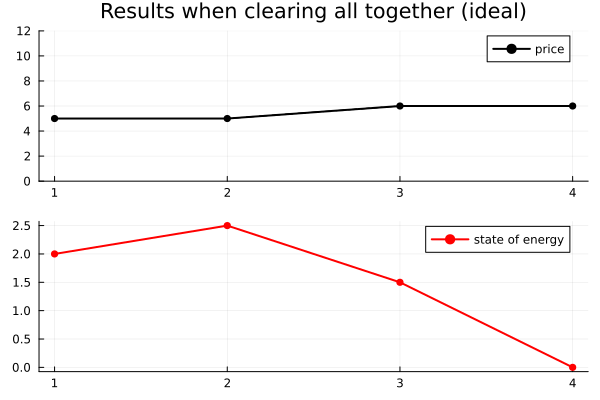

In [225]:
# Plot market price and state of energy vs t
max_y = max(maximum(G_df[:,:cost]),maximum(L_df[:,:utility]))
p_price = plot(T_all, results_df[!,"λ solver"].data, ylims=(0,max_y), label="price", color=:black, lw = 2, markershape=:circle, markerstrokewidth=0, title = "Results when clearing all together (ideal)")
plot!(T_all, results_df[!,"λ_min"], color=:black, linestyle=:dash, label="")
plot!(T_all, results_df[!,"λ_max"], color=:black, linestyle=:dash, label="")
p_soe = plot(T_all, results_df[!,"e"].data, label="state of energy", color=:red, lw = 2, markershape=:circle, markerstrokewidth=0)
plot(p_price, p_soe, layout = (2, 1))

## Market clearing, day by day

In this part of the code, the market is cleared day by day over the specified horizon, where the number of time periods constituting a day has been defined at the beginning of the code. First the final state of energy at the end of intermediate days and at the end of the horizon have to be decided. 

In [226]:
# Final state of energy at the end of one day:
## "no": constraint not included
## "ideal": optimal value
## "user value": predifined values in the csv file
final_level_d = "no"

# FINAL STATE OF ENERGY AT THE END OF THE HORIZON
## "no": constraint not included
## "ideal": optimal value
## "user value": predifined values in the csv file
final_level = "no"
;

In [227]:
# Prepare results
Dict_d = Dict()
Dict_p = Dict()
for l in L
    Dict_d["d$l"] = []
end
for g in G
    Dict_p["p$g"] = []
end
results_separate = Dict("e"=>[],"d"=> Dict_d,"p"=> Dict_p,"λ"=>[],"profit_stg"=>[], "sw"=> 0,"λ_min"=>[],"λ_max"=>[]);

t_start = 1

# Clear the market for each day in the horizon
for d in 1:nb_d
    global results_separate, E_init, t_start
    if d < nb_d
        if final_level_d == "ideal"
            final_level_d = results["e"][d*t_per_d]
        elseif final_level_d == "user value"
            final_level_d = E_df[d,"soe_end"]
        end
        t_end = t_start + t_per_d - 1
        T = [i for i in t_start:t_end]
        results_d = mc_storage(t_start, t_end, final_level_d, E_init)
        t_start += t_per_d
        
        # Update initial level to be equal to the final level of the previous day
        E_init = results_d["e"][t_per_d]
    else
        if final_level == "ideal"
            final_level = results["e"][d*t_per_d]
        elseif final_level == "user value"
            final_level = E_df[d,"soe_end"]
        end
        t_end = t_start + t_per_d - 1
        T = [i for i in t_start:t_end]
        results_d = mc_storage(t_start, t_end, final_level, E_init)
    end
    # Update results
    results_separate["e"] = append!(results_separate["e"],results_d["e"].data)
    for l in L
        res_d = []
        for t in T
            res_d = append!(res_d, results_d["d"][l,t])
        end
        results_separate["d"]["d$l"] = append!(results_separate["d"]["d$l"],res_d)
    end 
    for g in G
        res_p = []
        for t in T
            res_p = append!(res_p, results_d["p"][g,t])
        end
        results_separate["p"]["p$g"] = append!(results_separate["p"]["p$g"],res_p)
    end 
    results_separate["λ"] = append!(results_separate["λ"],results_d["λ"].data)
    results_separate["profit_stg"] = append!(results_separate["profit_stg"],results_d["profit_stg"])
    results_separate["sw"] = results_separate["sw"] + results_d["sw"]
    results_separate["λ_min"] = append!(results_separate["λ_min"],results_d["λ_min"])
    results_separate["λ_max"] = append!(results_separate["λ_max"],results_d["λ_max"])
end

In [228]:
# Display table with the results
res_separate_df = DataFrame()
res_separate_df.e = results_separate["e"]
for l in L
    res_separate_df.d = results_separate["d"]["d$l"]
    rename!(res_separate_df, :d => "d$l")
end
for g in G
    res_separate_df.p = results_separate["p"]["p$g"]
    rename!(res_separate_df, :p => "p$g")
end
res_separate_df.λ = results_separate["λ"]
rename!(res_separate_df, :λ => "λ solver")
res_separate_df.λ_min = results_separate["λ_min"]
res_separate_df.λ_max = results_separate["λ_max"]

res_separate_df.profit = results_separate["profit_stg"]

println("Total profit for the storage system: ",sum(results_separate["profit_stg"]))
println("Social welfare: ", results_separate["sw"])

res_separate_df

Total profit for the storage system: 0.0
Social welfare: 46.0


Row,e,d1,p1,p2,λ solver,λ_min,λ_max,profit
,Any,Any,Any,Any,Any,Any,Any,Any
1,1.0,-0.0,1.0,0.0,4.0,4,4,-4.0
2,0.0,1.0,0.0,0.0,4.0,4,4,4.0
3,1.0,3.0,2.0,2.0,9.0,9,11,-9.0
4,0.0,3.0,2.0,0.0,9.0,9,11,9.0


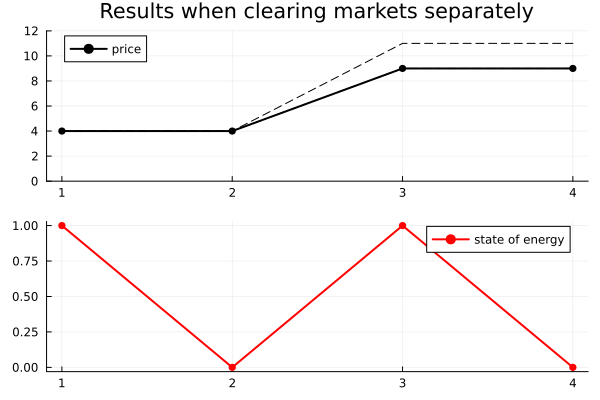

In [229]:
# Plot market price and state of energy vs t
p_price_sep = plot(T_all, res_separate_df[!,"λ solver"], ylims=(0,max_y), label="price", color=:black, lw = 2, markershape=:circle, markerstrokewidth=0, title = "Results when clearing markets separately")
plot!(T_all, res_separate_df[!,"λ_min"], color=:black, linestyle=:dash, label="")
plot!(T_all, res_separate_df[!,"λ_max"], color=:black, linestyle=:dash, label="")
p_soe_sep = plot(T_all, res_separate_df[!,"e"], label="state of energy", color=:red, lw = 2, markershape=:circle, markerstrokewidth=0)
plot(p_price_sep, p_soe_sep, layout = (2, 1))